IMPORTING NECESSARY LIBRARIES

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math
sns.set_style("whitegrid")

In [1]:
st = '2023-01-01'
ed = '2023-12-31'
benchmarkdf = yf.download(tickers = "^NSEMDCP50", start = st, end  = ed, progress = False, period = '1d')
benchmarkdf.drop(columns = ["Open","Low","High","Volume","Adj Close"], inplace = True)
benchmarkdf

NameError: name 'yf' is not defined

In [53]:
initial_investment = 10000
shares_bought = initial_investment / benchmarkdf['Close'][0]

benchmarkdf['Portfolio Value'] = benchmarkdf['Close']*shares_bought
benchmarkdf

,Close,Portfolio Value
Date,,
2023-01-02,8821.799805,10000.000000
2023-01-03,8843.349609,10024.427900
2023-01-04,8745.700195,9913.736867
2023-01-05,8808.599609,9985.036846
2023-01-06,8752.299805,9921.217890
...,...,...
2023-12-22,12838.200195,14552.812895
2023-12-26,12905.599609,14629.213874
2023-12-27,12946.500000,14675.576738


In [54]:
final_portfolio_value = benchmarkdf['Portfolio Value'][-1]
benchmark_returns = (final_portfolio_value - initial_investment)*100 / initial_investment
print("Benchmark Returns:", round(benchmark_returns,2),"%")

s = benchmarkdf['Portfolio Value']
s = np.log(s / s.shift(1))
s = s[1:]
sigma = (np.std(s)*math.sqrt(252))
s = s.mean()*252
print(sigma)
ra = s
print(ra)
rb = 0.07
benchmark_sr = ((ra-rb)/sigma) # Sharpe ratio
print("Benchmark Sharpe Ratio:", round(benchmark_sr,2))

Benchmark Returns: 49.01 %
0.12340268141198124
0.41188755604557037
Benchmark Sharpe Ratio: 2.77


<Axes: xlabel='Date'>

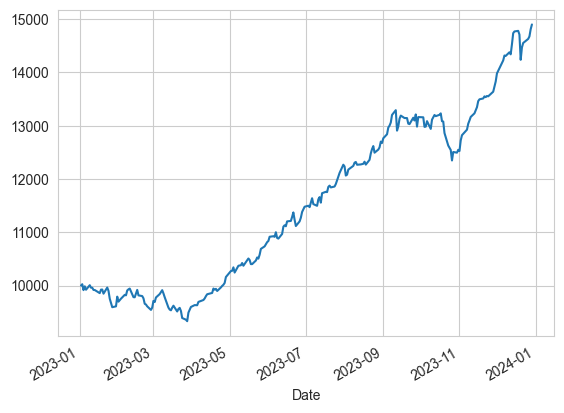

In [55]:
benchmarkdf['Portfolio Value'].plot(kind='line')

PULLING THE DATA AND FORMING A DATABASE

In [60]:
NUM_SIMULATIONS = 10000     # Tweak accordingly (can start with 5000-10000 for creating the code initially)
NUM_TRADING_DAYS = 252

stocks =["LUPIN.NS", "VOLTAS.NS", "NMDC.NS", "ZYDUSLIFE.NS", "SAIL.NS"]

In [57]:
from itertools import combinations
numbers = range(len(stocks))

# Generate all combinations of selecting 3 numbers
combs = list(combinations(numbers, 3))              # it will be something like [(0,1,2), (0,1,3)....]

In [58]:
for comb in combs:
  stocks_new = [stocks[i] for i in comb]
  stock_data = {}
  for stock in stocks_new:
      ticker = yf.Ticker(stock)
      print(ticker)
      stock_data[stock] = ticker.history(start=st, end=ed,)['Close']       #use the same start and end dates as the benchmark

yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <SAIL.NS>
yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker object <SAIL.NS>
yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
yfinance.Ticker object <SAIL.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker object <SAIL.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
yfinance.Ticker object <SAIL.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker object <ZYDUSLIFE

In [62]:
sim_port_list = []

for comb in combs:
  stocks_new = [stocks[i] for i in comb]
  stock_data = {}
  for stock in stocks_new:
      ticker = yf.Ticker(stock)
      print(ticker)
      stock_data[stock] = ticker.history(start=st, end=ed)['Close']       #use the same start and end dates as the benchmark

  stock_prices = pd.DataFrame(stock_data)

  log_returns = np.log(stock_prices/stock_prices.shift(1))
  log_returns = log_returns[1:]         # Remove NaN values

  portfolio_weights = []
  portfolio_returns = []
  portfolio_risks = []

  for i in range(NUM_SIMULATIONS):
    #your code here
    
    # 1) generate random weights
    
    w = np.random.rand(log_returns.shape[1])
    w /= np.sum(2)
    
    # 2) update the list portfolio_weights
    
    portfolio_weights.append(w)
    
    # 3) update the list portfolio_returns
    
    p_returns = np.sum(log_returns.mean()*w)*NUM_TRADING_DAYS
    portfolio_returns.append(p_returns)
    
    # 4) update the list portfolio_risks
    
    p_risks = np.sqrt(np.dot(w.T, np.dot(log_returns.cov()*NUM_TRADING_DAYS,w)))
    portfolio_risks.append(p_risks)

  risk_free_rate = 0.07
  porfolio_weights = np.array(portfolio_weights)
  portfolio_returns = np.array(portfolio_returns)
  portfolio_risks = np.array(portfolio_risks)


  sharpe_ratios  = (portfolio_returns - risk_free_rate) / portfolio_risks

  portfolios = pd.DataFrame({"Return": portfolio_returns,"Risk": portfolio_risks,"Sharpe": sharpe_ratios })
  ind = np.argmax(sharpe_ratios)

  weights = np.array(portfolio_weights[ind])
  first_day_prices = np.array(stock_prices.iloc[0,:]) 
  
  df = stock_prices.copy()
  individual_value = weights*initial_investment
  shares = individual_value / first_day_prices

  # create a column in df named "Portfolio Value" which is our portfolio value, if we buy the corresponding three stocks in the weights we just got on the first day
  df['Portfolio Value'] = np.sum(np.array(stock_prices)*shares,axis=1)
  # Hint:
      # Calculate the shares bought for each on the first day.
      # use this calculated value and multiply with close of each day to get portfolio value on that stock on the day.
      # now add the individual stock portfolios to get the final portfolio value on the day.

  final_portfolio_value = df['Portfolio Value'][-1]

  df_returns = (final_portfolio_value - initial_investment)*100 / initial_investment

  print("Combo Returns:", round(df_returns,2),"%")
  
  df_sr = sharpe_ratios[ind]
  print("Combo Sharpe Ratio:", round(df_sr,2))
  
  row = [stocks_new, np.round_(shares, decimals=2), np.round_(final_portfolio_value, decimals=2), round(df_returns,2), round(df_sr,2)]
  sim_port_list.append(row)

pd.DataFrame(sim_port_list, columns=['Stocks in Portfolio','Shares','Final Portfolio Value','Portfolio Return','Sharpe Ratio'])

yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <NMDC.NS>
Combo Returns: 95.34 %
Combo Sharpe Ratio: 2.61
yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
Combo Returns: 99.17 %
Combo Sharpe Ratio: 2.57
yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <SAIL.NS>
Combo Returns: 39.0 %
Combo Sharpe Ratio: 2.18
yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
Combo Returns: 157.78 %
Combo Sharpe Ratio: 2.95
yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker object <SAIL.NS>
Combo Returns: 68.54 %
Combo Sharpe Ratio: 2.53
yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
yfinance.Ticker object <SAIL.NS>
Combo Returns: 92.05 %
Combo Sharpe Ratio: 2.59
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker object 

,Stocks in Portfolio,Shares,Final Portfolio Value,Portfolio Return,Sharpe Ratio
0,"[LUPIN.NS, VOLTAS.NS, NMDC.NS]","[6.81, 2.37, 40.13]",19534.45,95.34,2.61
1,"[LUPIN.NS, VOLTAS.NS, ZYDUSLIFE.NS]","[6.85, 2.98, 11.52]",19916.79,99.17,2.57
2,"[LUPIN.NS, VOLTAS.NS, SAIL.NS]","[6.8, 2.87, 17.04]",13900.46,39.00,2.18
3,"[LUPIN.NS, NMDC.NS, ZYDUSLIFE.NS]","[6.83, 42.86, 11.57]",25777.96,157.78,2.95
4,"[LUPIN.NS, NMDC.NS, SAIL.NS]","[6.82, 37.8, 0.79]",16853.77,68.54,2.53
5,"[LUPIN.NS, ZYDUSLIFE.NS, SAIL.NS]","[6.85, 11.84, 16.19]",19205.12,92.05,2.59
6,"[VOLTAS.NS, NMDC.NS, ZYDUSLIFE.NS]","[2.3, 41.21, 11.83]",18831.70,88.32,2.57
7,"[VOLTAS.NS, NMDC.NS, SAIL.NS]","[4.73, 42.8, 9.58]",14559.23,45.59,1.76
8,"[VOLTAS.NS, ZYDUSLIFE.NS, SAIL.NS]","[2.45, 12.01, 21.21]",13274.39,32.74,2.03
9,"[NMDC.NS, ZYDUSLIFE.NS, SAIL.NS]","[40.58, 11.9, 1.0]",16624.96,66.25,2.51


Output should have the ticker of the stocks in the combo and their corresponding Combo return and Combo max sharpe ratio.
For all the Combos!

Access the output and see if there are any portfolios which out-perform the benchmark. You can also automate this part of manually looking at all the portfolios!

You know have enough knowlegde to test this and see how various portfolios work!
